Metodo

ResNet-AvgPool-1024: Ridimensiona l'immagine a 224x24; collega un "hook" all'output del livello "avgpool" dell'architettura pre-addestrata ResNet per ottenere un vettore di dimensione 2048, riduci il numero di dimensioni del vettore a 1024 calcolando la media di due voci consecutive nel vettore. 

** Spiegare il metodo nel dettaglio ** 

In [89]:
# === Built-in ===
import os

# === Third-party ===
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from scipy.spatial.distance import mahalanobis

# === PyTorch ===
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from collections import defaultdict

from sklearn.preprocessing import normalize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from PIL import Image

import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report,pairwise_distances

#import umap

# Task 1-2

Implementa un programma che estrae e memorizza i descrittori di feature per tutte le immagini nel set di dati

In [90]:
class ResNetAvgPool1024Extractor:
    def __init__(self):
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        self.feature = None
        self.model.avgpool.register_forward_hook(self._hook_avgpool)

        self.transform = transforms.Compose([
            transforms.Resize((224, 24)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def _hook_avgpool(self, module, input, output):
        self.feature = output.squeeze().detach().numpy()

    def extract_feature(self, image_path):
        img = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(img).unsqueeze(0)
        with torch.no_grad():
            _ = self.model(input_tensor)

        feat_2048 = self.feature
        return 0.5 * (feat_2048[::2] + feat_2048[1::2])  # Ridotto a 1024

Estrazione,Salvataggio e Caricamneto delle Feature 

In [91]:
def process_and_save_features(base_folder, subfolders, output_file):
    extractor = ResNetAvgPool1024Extractor()
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extractor.extract_feature(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")


def load_features(file_path):
    data = np.load(file_path, allow_pickle=True)
    return data["features"], data["filenames"], data["labels"]

Visualizzazione dei Risultati

In [92]:
def plot_matches(query_path, indices, labels, filenames, distances, metric_label):
    k = len(indices)
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))

    # Immagine query
    axs[0].imshow(cv2.cvtColor(cv2.imread(query_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    # Immagini simili
    for i, idx in enumerate(indices):
        img_path = os.path.join("Part1", labels[idx], filenames[idx])
        match_img = cv2.imread(img_path)
        axs[i + 1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i+1}\n{metric_label}={distances[idx]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Task 3

 Implementa un programma che, dato il nome di un file immagine e un valore "k", restituisce e visualizza le k immagini più simili in base a ciascun modello visivo - selezionerai l'appropriata misura di distanza/similarità per ciascun modello di feature.  Per ogni corrispondenza, elenca anche il corrispondente punteggio di distanza/similarità. 

  *Retrieval: Immagini più Simili (distanza coseno)*
 

In [152]:
def find_k_similar(img_path, k, extractor, features, filenames, labels):
    query_feature = extractor.extract_feature(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    dist_euc = euclidean_distances(features, query_feature).flatten()
    dist_cos = cosine_distances(features, query_feature).flatten()

    top_k_idx_euc = np.argsort(dist_euc)[:k]
    top_k_idx_cos = np.argsort(dist_cos)[:k]

    print(f"\nTop {k} simili a {img_path}:")
    print("=== Euclide ===")
    for rank, idx in enumerate(top_k_idx_euc):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Euclid: {dist_euc[idx]:.4f}")

    print("=== Coseno ===")
    for rank, idx in enumerate(top_k_idx_cos):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Cosine: {dist_cos[idx]:.4f}")

    # Visualizza entrambi
    plot_matches(img_path, top_k_idx_euc, labels, filenames, dist_euc, "Euclid")
    plot_matches(img_path, top_k_idx_cos, labels, filenames, dist_cos, "Cosine")

    plot_distance_analysis(dist_euc, top_k_idx_euc, "euclidean")
    plot_distance_analysis(dist_cos, top_k_idx_cos, "cosine")


Ricerca Immagini Simili - Mahalanobis -- Task 3

In [153]:
def find_k_similar_mahalanobis(img_path, k, extractor, features, filenames, labels):
    query_feature = extractor.extract_feature(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature)
    cov = np.cov(features.T)
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("[ERRORE] Covarianza non invertibile. Uso pseudoinversa.")
        cov_inv = np.linalg.pinv(cov)

    distances = np.array([mahalanobis(query_feature, f, cov_inv) for f in features])
    top_k_idx = np.argsort(distances)[:k]

    print(f"\nTop {k} simili (Mahalanobis) a {img_path}:")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {distances[idx]:.2f}")

    plot_matches(img_path, top_k_idx, labels, filenames, distances, "M")
    plot_distance_analysis(distances, top_k_idx, "mahalanobis")


Esecuzione

In [96]:
# === Parametri ===
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# === Estrai e salva features (solo una volta) ===
process_and_save_features("Part1", subfolders, "resnet1024_pt1.npz")
process_and_save_features("Part2", subfolders, "resnet1024_pt2.npz")

# === Carica features ===
features_pt1, filenames_pt1, labels_pt1 = load_features("resnet1024_pt1.npz")
features_pt2, filenames_pt2, labels_pt2 = load_features("resnet1024_pt2.npz")

# === Inizializza extractor ===
extractor = ResNetAvgPool1024Extractor()

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet1024_pt1.npz
[FINE] Totale immagini processate: 3006
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet1024_pt2.npz
[FINE] Totale immagini processate: 3006


Test


Top 5 simili a Part1/brain_glioma/brain_glioma_0005.jpg:
=== Euclide ===
1. brain_glioma_0005.jpg | Classe: brain_glioma | Euclid: 0.0000
2. brain_glioma_0258.jpg | Classe: brain_glioma | Euclid: 5.5544
3. brain_glioma_0071.jpg | Classe: brain_glioma | Euclid: 5.6090
4. brain_glioma_0311.jpg | Classe: brain_glioma | Euclid: 6.8896
5. brain_glioma_0323.jpg | Classe: brain_glioma | Euclid: 7.5799
=== Coseno ===
1. brain_glioma_0005.jpg | Classe: brain_glioma | Cosine: 0.0000
2. brain_glioma_0258.jpg | Classe: brain_glioma | Cosine: 0.0443
3. brain_glioma_0071.jpg | Classe: brain_glioma | Cosine: 0.0455
4. brain_glioma_0311.jpg | Classe: brain_glioma | Cosine: 0.0681
5. brain_glioma_0323.jpg | Classe: brain_glioma | Cosine: 0.0844


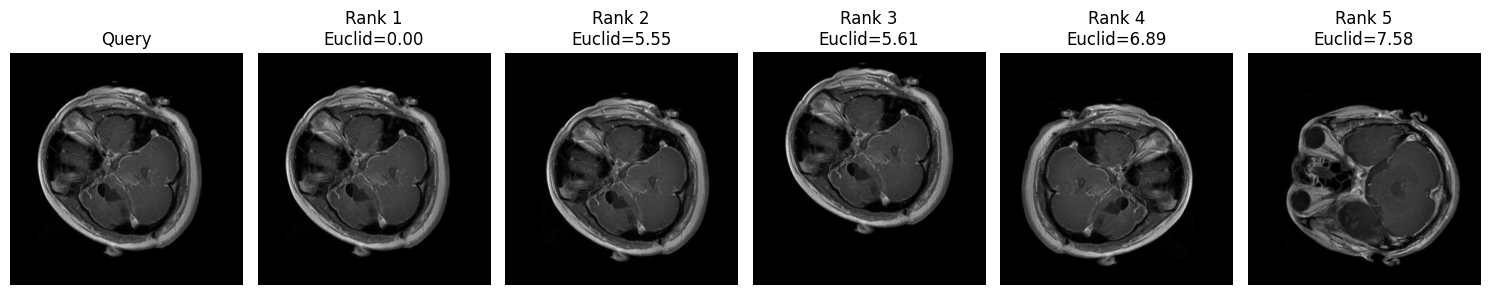

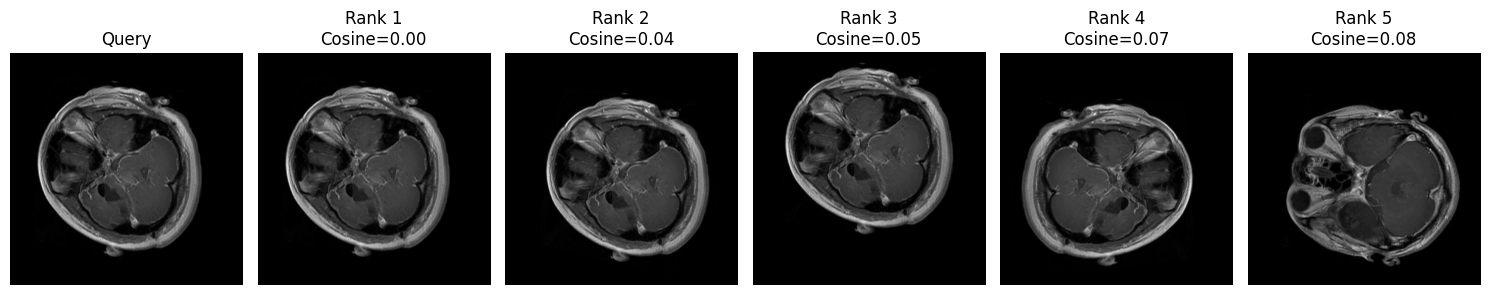

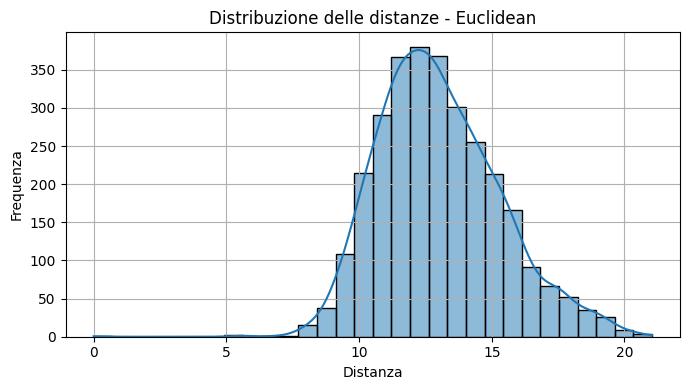

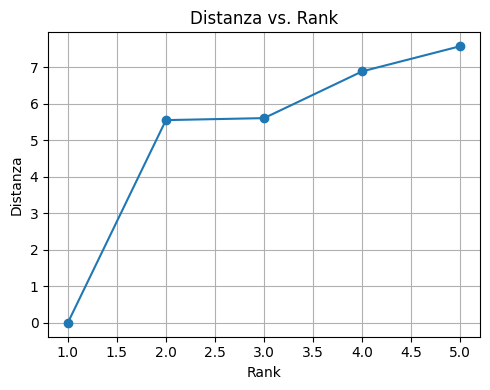

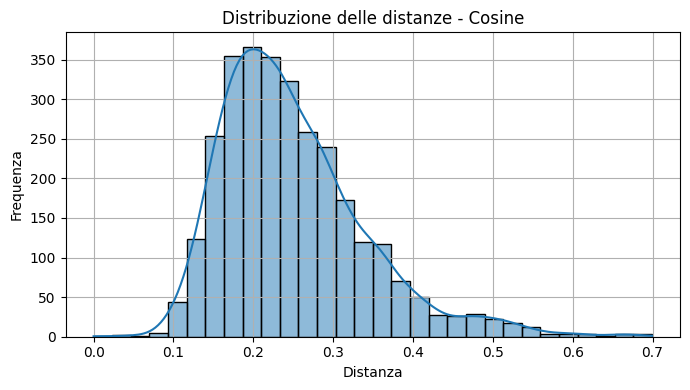

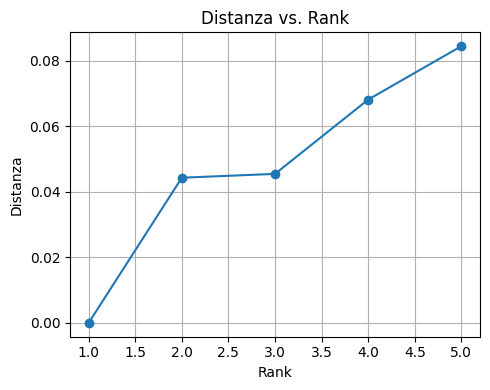


Top 5 simili (Mahalanobis) a Part1/brain_glioma/brain_glioma_0005.jpg:
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 30.88
3. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 30.94
4. brain_menin_0196.jpg | Classe: brain_menin | Distanza: 31.50
5. brain_glioma_0549.jpg | Classe: brain_glioma | Distanza: 31.55


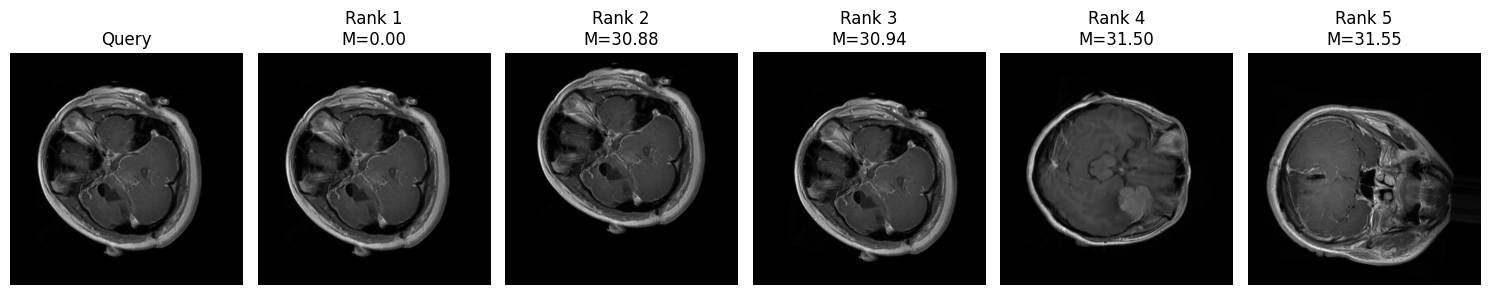

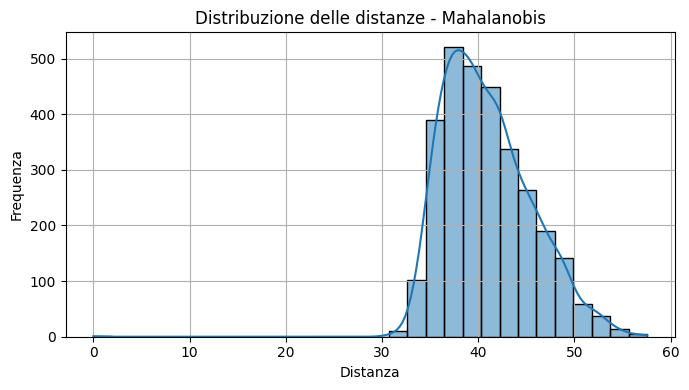

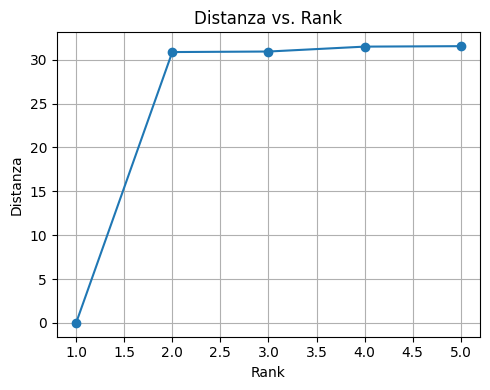

In [154]:
# === Query ===
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(query_img, k=5, extractor=extractor, features=features_pt1, filenames=filenames_pt1, labels=labels_pt1)
find_k_similar_mahalanobis(query_img, k=5, extractor=extractor, features=features_pt1, filenames=filenames_pt1, labels=labels_pt1)

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distance_analysis(distances, top_k_idx, distance_type="euclidean"):
    plt.figure(figsize=(7, 4))
    sns.histplot(distances, bins=30, kde=True)
    plt.title(f"Distribuzione delle distanze - {distance_type.capitalize()}")
    plt.xlabel("Distanza")
    plt.ylabel("Frequenza")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 4))
    ranks = list(range(1, len(top_k_idx) + 1))
    top_d = distances[top_k_idx]
    plt.plot(ranks, top_d, marker='o')
    plt.title("Distanza vs. Rank")
    plt.xlabel("Rank")
    plt.ylabel("Distanza")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Task 4:

 Implementa un programma che, dati (a) un file immagine di query della parte 2, (b) uno spazio di feature selezionato dall'utente e (c) un numero intero positivo k (k<=2), identifica ed elenca le k etichette di corrispondenza più probabili, insieme ai loro punteggi, nello spazio di feature selezionato.    

In [99]:
def compute_metric(query_feat, target_feats, metric="euclidean"):
    query_feat = query_feat.reshape(1, -1)
    if metric == "euclidean":
        return euclidean_distances(target_feats, query_feat).flatten()
    elif metric == "cosine":
        return cosine_similarity(query_feat, target_feats).flatten()
    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

def predict_top_k_labels_distance_mean_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    query_feat = extractor.extract_feature(query_img_path)
    if query_feat is None:
        print("[ERRORE] Feature non estratte.")
        return

    unique_labels = np.unique(labels)
    scores = []

    for label in unique_labels:
        class_feats = features[labels == label]
        dists_or_sims = compute_metric(query_feat, class_feats, metric)
        score = dists_or_sims.mean()
        scores.append(score)

    if metric == "euclidean":
        top_k = np.argsort(scores)[:k]
    else:
        top_k = np.argsort(scores)[::-1][:k]

    print(f"\n[STRATEGIA: distanza media - metrica: {metric}]")
    for idx in top_k:
        print(f"Classe: {unique_labels[idx]} | Score medio: {scores[idx]:.4f}")

def predict_top_k_labels_prototype_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    query_feat = extractor.extract_feature(query_img_path)
    if query_feat is None:
        print("[ERRORE] Feature non estratte.")
        return

    unique_labels = np.unique(labels)
    class_prototypes = []
    for label in unique_labels:
        class_feats = features[labels == label]
        class_prototypes.append(class_feats.mean(axis=0))
    class_prototypes = np.vstack(class_prototypes)

    scores = compute_metric(query_feat, class_prototypes, metric)

    if metric == "euclidean":
        top_k = np.argsort(scores)[:k]
    else:
        top_k = np.argsort(scores)[::-1][:k]

    print(f"\n[STRATEGIA: prototipo di classe - metrica: {metric}]")
    for idx in top_k:
        print(f"Classe: {unique_labels[idx]} | Score: {scores[idx]:.4f}")

def task4_predict_labels_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    assert k <= 2, "k deve essere <= 2"
    print(f"\n======== PREDIZIONE PER: {os.path.basename(query_img_path)} ========")
    predict_top_k_labels_distance_mean_1024(query_img_path, k, extractor, features, labels, metric)
    predict_top_k_labels_prototype_1024(query_img_path, k, extractor, features, labels, metric)

Test

In [100]:
query_img = "Part2/brain_menin/brain_menin_1202.jpg"
task4_predict_labels_1024(query_img, k=2, extractor=extractor, features=features_pt2, labels=labels_pt2, metric="euclidean")
task4_predict_labels_1024(query_img, k=2, extractor=extractor, features=features_pt2, labels=labels_pt2, metric="cosine")


======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: euclidean]
Classe: brain_menin | Score medio: 13.5232
Classe: brain_tumor | Score medio: 13.6722

[STRATEGIA: prototipo di classe - metrica: euclidean]
Classe: brain_tumor | Score: 8.4114
Classe: brain_menin | Score: 9.6109

======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: cosine]
Classe: brain_tumor | Score medio: 0.7305
Classe: brain_menin | Score medio: 0.7206

[STRATEGIA: prototipo di classe - metrica: cosine]
Classe: brain_tumor | Score: 0.8891
Classe: brain_menin | Score: 0.8517


# Task 5

Implementa un programma che (a) dato uno dei modelli di feature, (b) un valore k specificato dall'utente, (c) una delle tre tecniche di riduzione della dimensionalità (SVD, LDA, k-means) scelte dall'utente, riporta le prime k semantiche latenti estratte nello spazio di feature selezionato.    

-Memorizza le semantiche latenti in un file di output adeguatamente nominato.    

-Elenca le coppie imageID-peso, ordinate in ordine decrescente di pesi.    


In [149]:

from collections import Counter

def plot_latent_semantic_distributions(weights, labels, k, top_n=50):
    # === GRAFICO 1: Istogrammi dei pesi ===
    plt.figure(figsize=(4 * k, 4))
    for i in range(k):
        plt.subplot(1, k, i + 1)
        sns.histplot(weights[:, i], bins=30, kde=True)
        plt.title(f"Latent Semantic {i+1}")
        plt.xlabel("Weight")
    plt.tight_layout()
    plt.show()

    # === GRAFICO 2: Distribuzione classi nei top-n pesi ===
    if k <= 3:
        rows, cols = 1, k
    elif k <= 6:
        rows, cols = 2, 3
    elif k <= 9:
        rows, cols = 3, 3
    elif k <= 12:
        rows, cols = 3, 4
    else:
        rows = int(np.ceil(np.sqrt(k)))
        cols = int(np.ceil(k / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten() if k > 1 else [axes]

    for i in range(k):
        top_idx = np.argsort(-np.abs(weights[:, i]))[:top_n]
        top_classes = [labels[idx] for idx in top_idx]
        class_counts = Counter(top_classes)

        ax = axes[i]
        sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=ax)
        ax.set_title(f"Top-{top_n} Class Distribution - Semantic {i+1}")
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=45)

    for i in range(k, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()


def task5_latent_semantics_resnet1024(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature ResNet AvgPool1024
    usando SVD, LDA o KMeans. Salva i risultati su file e visualizza lo spazio latente.
    """
    # === Carica feature ===
    data = np.load(feature_model_path, allow_pickle=True)
    feature_matrix = data["features"]
    filenames = data["filenames"]
    labels = data["labels"]

    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # === Visualizzazione 2D ===
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    # === Salvataggio output ===

    output_dir = os.path.join("task5_output", "latent_semantics_1024")
    os.makedirs(output_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = os.path.join(output_dir, f"tutti_i_pesi_{method}_{base_name}_k{k}.txt")

    # === Costruzione matrice dei pesi latenti
    if technique in ["svd", "lda"]:
        latent_matrix = X_transformed  # (n_samples, k)
    else:  # kmeans: inverti distanza per coerenza
        latent_matrix = -X_transformed
    plot_latent_semantic_distributions(latent_matrix, labels, k)

    # === Salvataggio tabellare completo (riga per immagine)
    with open(out_file, "w") as f:
        header = "ImageID | Class" + "".join([f" | Peso{i+1}" for i in range(k)]) + "\n"
        f.write(header)
        for idx, img in enumerate(filenames):
            weights = latent_matrix[idx]
            line = f"{img} | {labels[idx]}" + "".join([f" | {w:.4f}" for w in weights]) + "\n"
            f.write(line)

    

    print(f"[SALVATO] Latent semantics (tabellare) salvati in: {out_file}")

In [142]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D dello spazio latente."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza i cluster KMeans in 2D usando SVD per proiezione."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

Test

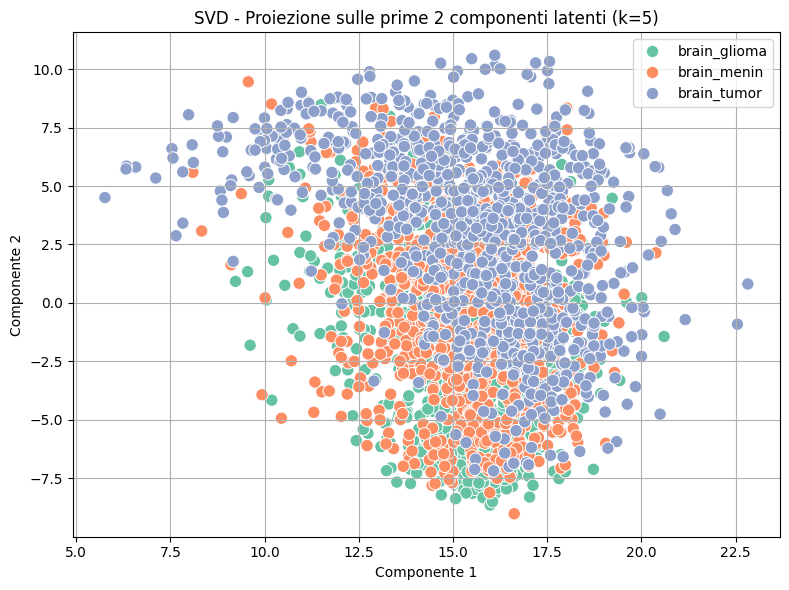

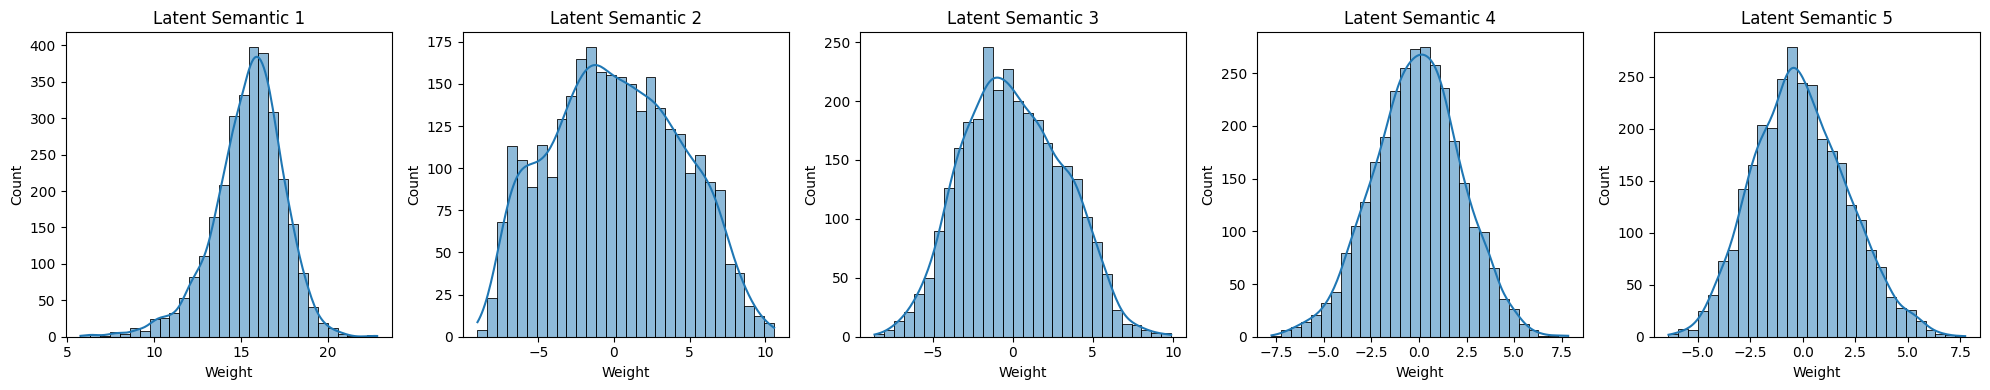

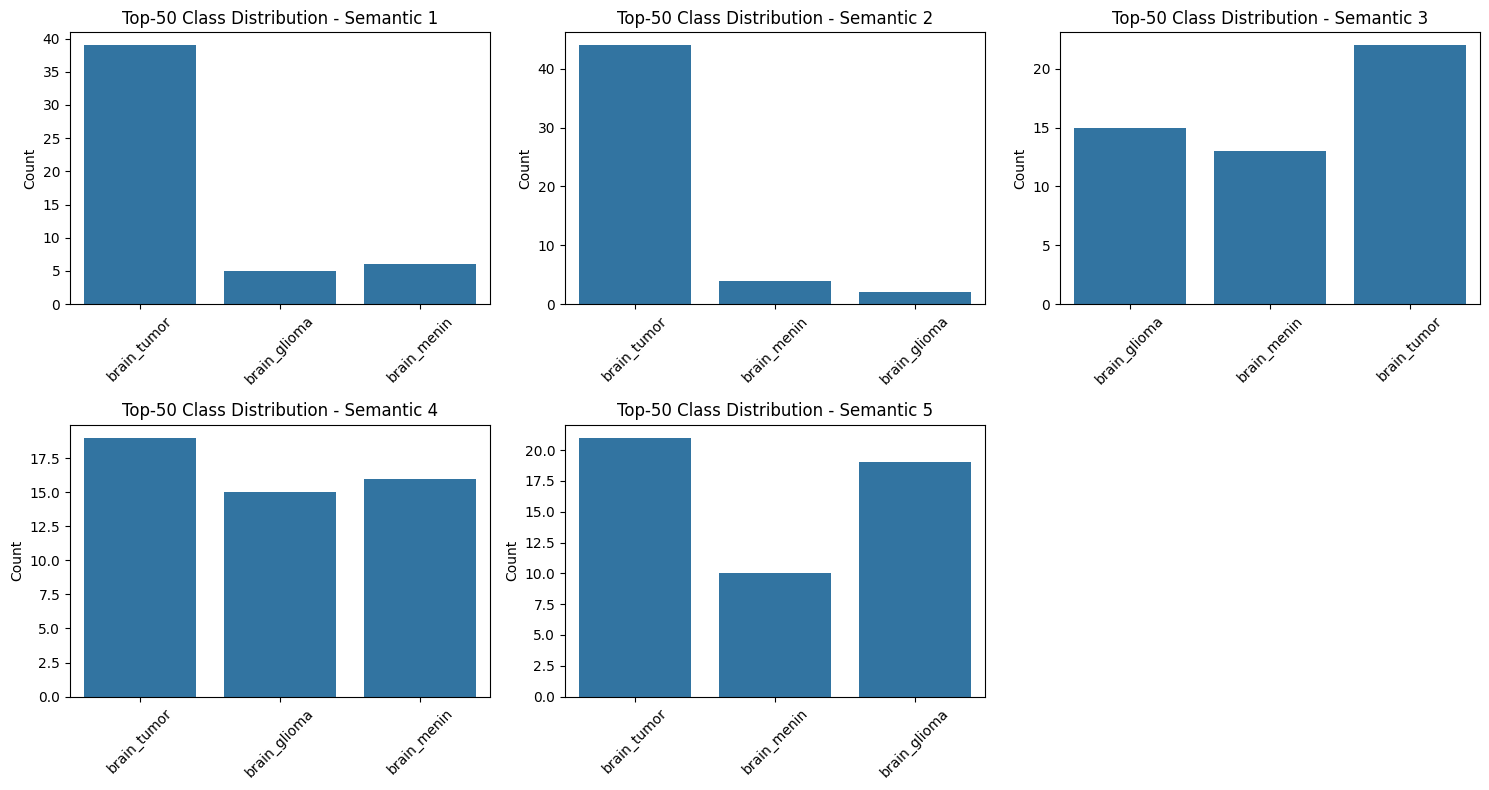

[SALVATO] Latent semantics (tabellare) salvati in: task5_output\latent_semantics_1024\tutti_i_pesi_svd_resnet1024_pt1_k5.txt


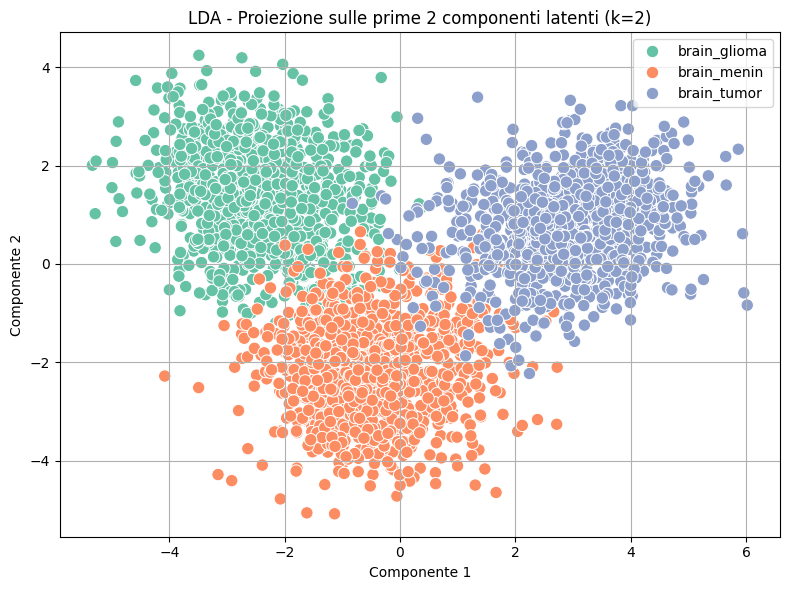

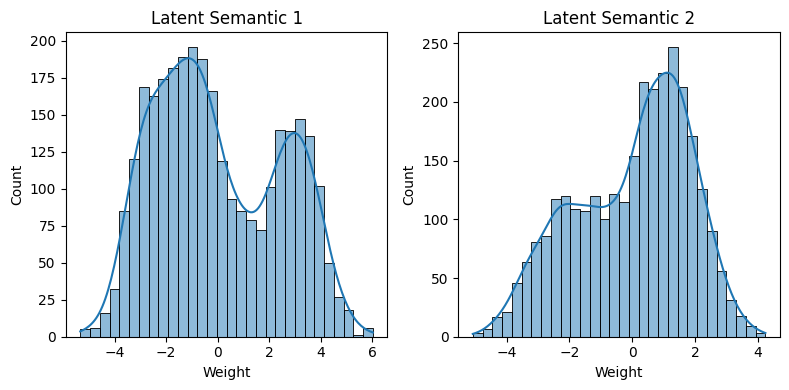

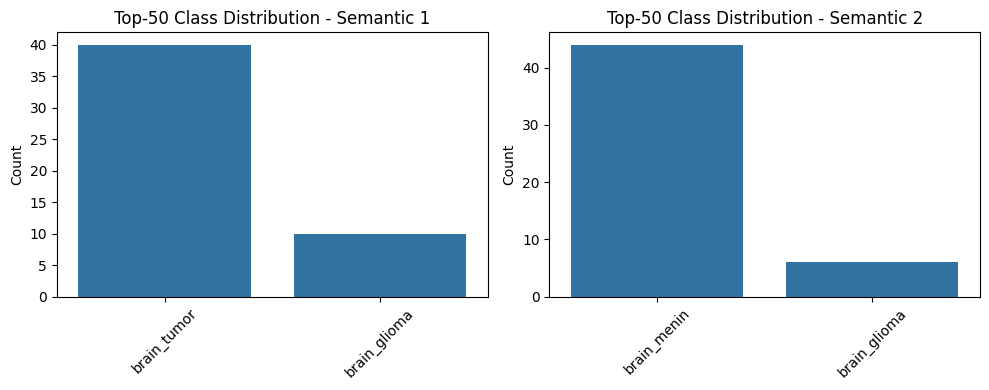

[SALVATO] Latent semantics (tabellare) salvati in: task5_output\latent_semantics_1024\tutti_i_pesi_lda_resnet1024_pt1_k2.txt


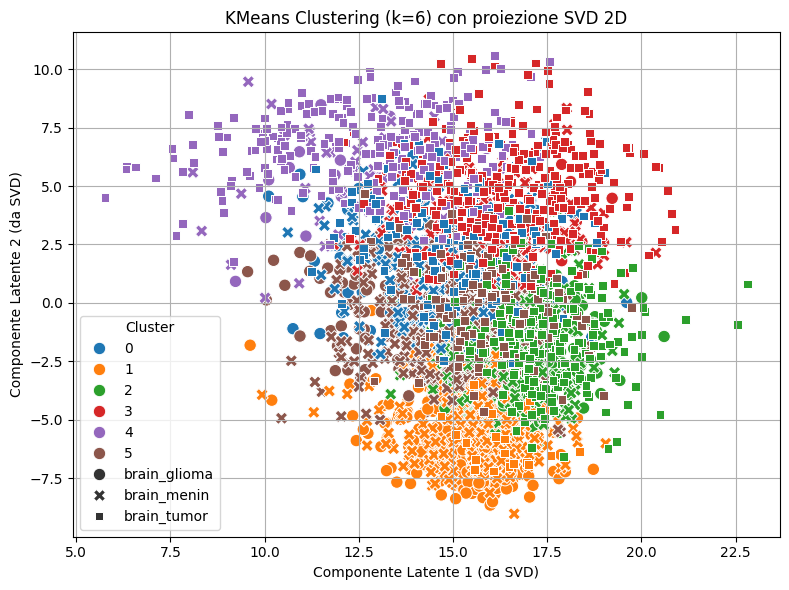

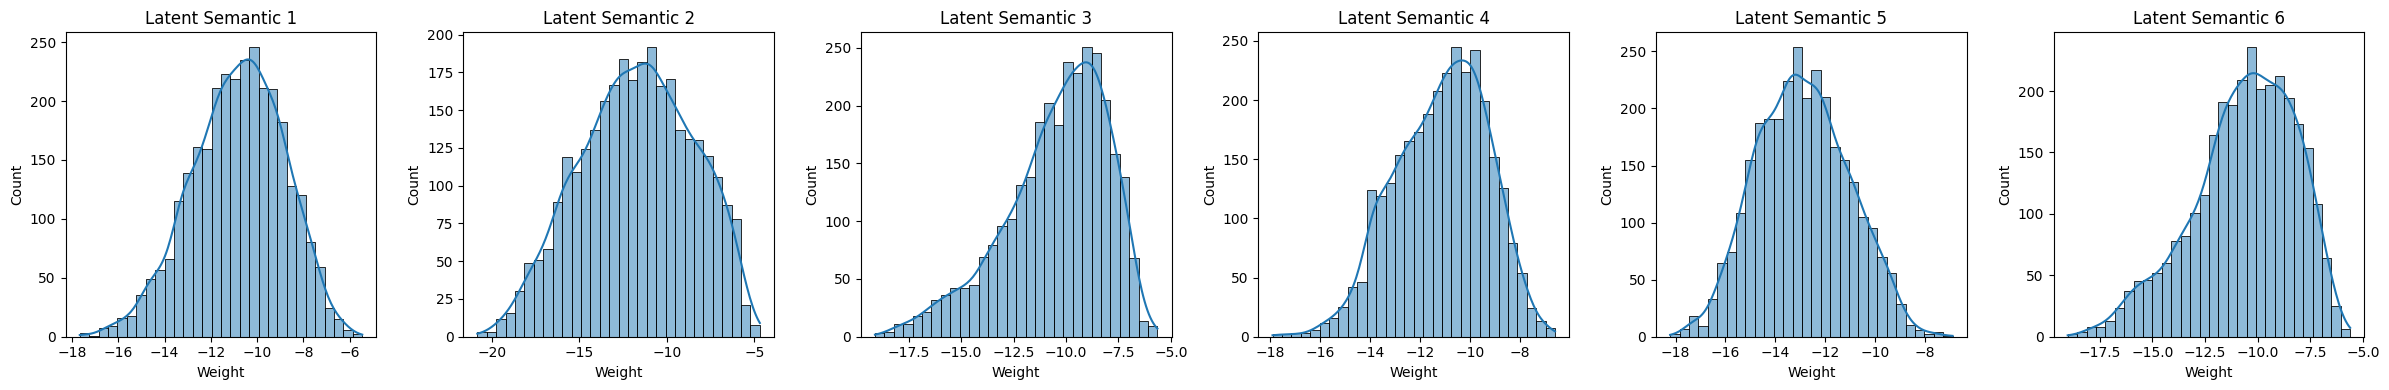

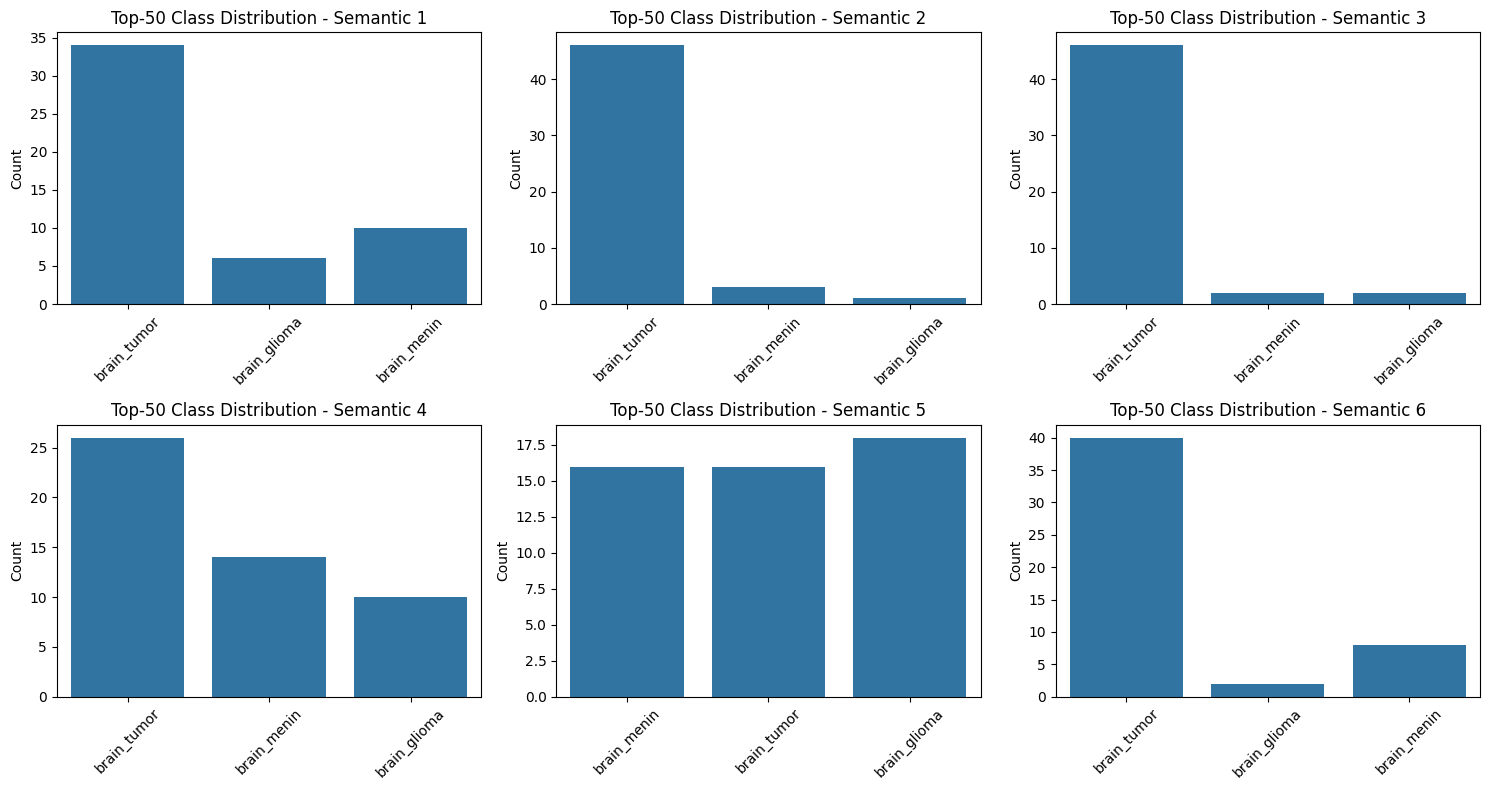

[SALVATO] Latent semantics (tabellare) salvati in: task5_output\latent_semantics_1024\tutti_i_pesi_kmeans_resnet1024_pt1_k6.txt


In [150]:
# === ESEMPIO USO ===
task5_latent_semantics_resnet1024("resnet1024_pt1.npz", technique="svd", k=5)
task5_latent_semantics_resnet1024("resnet1024_pt1.npz", technique="lda", k=2)
task5_latent_semantics_resnet1024("resnet1024_pt1.npz", technique="kmeans", k=6)

# Task 6


>Task 6a:

 Implementa un programma che calcola e stampa la "inherent dimensionality" associata alle immagini della parte 1.    


In [105]:
def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA su ResNet1024)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative


def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


Test


Task 6a – Dimensionalità intrinseca (globale):

[INFO] Feature matrix shape: (3006, 1024)
[INFO] k ottimale suggerito (soglia 90%): 123
Soglia 90% : k = 123
[INFO] k ottimale suggerito (soglia 95%): 225
Soglia 95% : k = 225
[INFO] k ottimale suggerito (soglia 99%): 485
Soglia 99% : k = 485


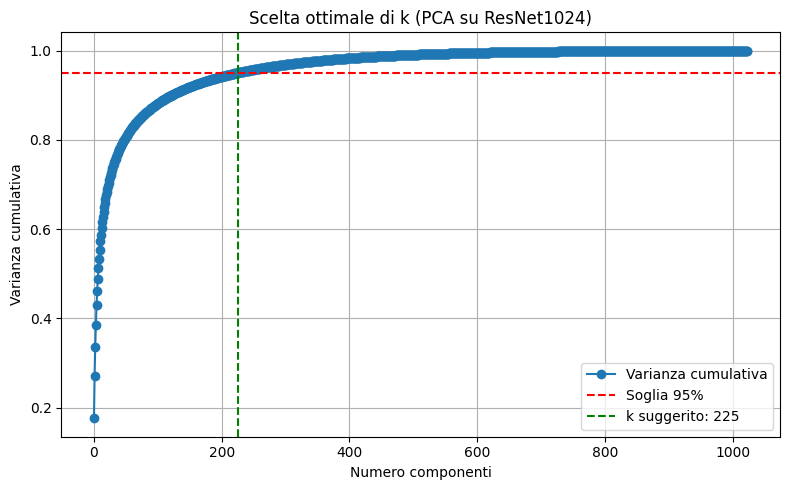

[INFO] k ottimale suggerito (soglia 95%): 225


(225,
 array([0.17615518, 0.2706146 , 0.3369987 , ..., 0.9999994 , 0.9999995 ,
        0.9999996 ], dtype=float32))

In [106]:
print("\nTask 6a – Dimensionalità intrinseca (globale):\n")
k_suggeriti_resnet1024 = suggest_k(features_pt1)
estimate_intrinsic_dimensionality(features_pt1, threshold=0.95, plot=True)


> Task 6b: 

Implementa un programma che calcola e stampa la "dimensionalità intrinseca" (numero di dim indipendenti minime necassari per rappresentare set) associata a ciascuna etichetta univoca delle immagini della parte 1.  

In [107]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}
    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(np.array(labels) == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" • Label '{label}' : k = {k}")
    return label_dim_map

Test

In [108]:
print("\nTask 6b – Dimensionalità intrinseca per etichetta (ResNet1024):\n")
label_dimensionalities_resnet1024 = estimate_dimensionality_per_label(
    features_pt1, labels_pt1, threshold=0.95
)


Task 6b – Dimensionalità intrinseca per etichetta (ResNet1024):

[INFO] Etichette uniche trovate: 3
[INFO] k ottimale suggerito (soglia 95%): 167
 • Label 'brain_glioma' : k = 167
[INFO] k ottimale suggerito (soglia 95%): 186
 • Label 'brain_menin' : k = 186
[INFO] k ottimale suggerito (soglia 95%): 192
 • Label 'brain_tumor' : k = 192


# Task 7

Implementa un programma che,per ciascuna etichetta univoca l, calcola le corrispondenti k semantiche latenti (a tua scelta) associate alle immagini della parte 1, e
per le immagini della parte 2, prevede le etichette più probabili utilizzando distanze/similarità calcolate sotto le semantiche latenti specifiche dell'etichetta.    
Il sistema dovrebbe anche fornire valori di precision, recall, and F1-score per etichetta, nonché un valore di accuratezza complessiva.   

In [109]:
def compute_latent_semantics_per_class_resnet(X, y, k=10):
    class_models = {}
    class_means = {}
    labels = np.unique(y)

    for label in labels:
        X_class = X[np.array(y) == label]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)

        svd = TruncatedSVD(n_components=k, random_state=42)
        latent = svd.fit_transform(X_scaled)

        class_models[label] = {
            'scaler': scaler,
            'svd': svd,
            'latent_vectors': latent
        }
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_labels_with_latent_semantics(X_test, class_models, class_means):
    predictions = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))
            x_latent = model['svd'].transform(x_scaled)
            dist = np.linalg.norm(x_latent - class_means[label])
            if dist < min_dist:
                min_dist = dist
                best_label = label
        predictions.append(best_label)
    return predictions

def evaluate_predictions(y_true, y_pred):
    print("[VALUTAZIONE] Metriche per classe:")
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    accuracy = accuracy_score(y_true, y_pred)
    for label, p, r, f in zip(np.unique(y_true), precision, recall, f1):
        print(f"Classe {label}: Precisione={p:.2f}, Recall={r:.2f}, F1-Score={f:.2f}")
    print(f"\nAccuratezza globale: {accuracy:.2f}\n")
    print(classification_report(y_true, y_pred))

Test

In [110]:
# ====== ESECUZIONE ======

# Step 1: addestramento sulle immagini Part1
class_models_resnet1024, class_means_resnet1024 = compute_latent_semantics_per_class_resnet(
    features_pt1, labels_pt1, k=10
)

# Step 2: predizione sulle immagini Part2
predicted_labels_resnet1024 = predict_labels_with_latent_semantics(
    features_pt2, class_models_resnet1024, class_means_resnet1024
)

# Step 3: valutazione delle predizioni
evaluate_predictions(labels_pt2, predicted_labels_resnet1024)

[VALUTAZIONE] Metriche per classe:
Classe brain_glioma: Precisione=0.52, Recall=0.45, F1-Score=0.48
Classe brain_menin: Precisione=0.33, Recall=0.21, F1-Score=0.25
Classe brain_tumor: Precisione=0.47, Recall=0.70, F1-Score=0.56

Accuratezza globale: 0.45

              precision    recall  f1-score   support

brain_glioma       0.52      0.45      0.48      1002
 brain_menin       0.33      0.21      0.25      1002
 brain_tumor       0.47      0.70      0.56      1002

    accuracy                           0.45      3006
   macro avg       0.44      0.45      0.43      3006
weighted avg       0.44      0.45      0.43      3006



In [159]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_and_plot_confusion(y_true, y_pred, labels_order=None):
    """
    Mostra una confusion matrix e stampa le metriche di classificazione.
    """
    if labels_order is None:
        labels_order = np.unique(np.concatenate([y_true, y_pred]))

    # === Metriche per classe ===
    print("[VALUTAZIONE] Metriche per classe:")
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_order, average=None, zero_division=0
    )
    accuracy = accuracy_score(y_true, y_pred)

    for label, p, r, f in zip(labels_order, precision, recall, f1):
        print(f"Classe {label}: Precisione={p:.2f}, Recall={r:.2f}, F1-Score={f:.2f}")
    print(f"\nAccuratezza globale: {accuracy:.2f}")
    print(classification_report(y_true, y_pred, labels=labels_order))

    # === Matrice di confusione ===
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix – Task 7")
    plt.tight_layout()
    plt.show()


[VALUTAZIONE] Metriche per classe:
Classe brain_glioma: Precisione=0.52, Recall=0.45, F1-Score=0.48
Classe brain_menin: Precisione=0.33, Recall=0.21, F1-Score=0.25
Classe brain_tumor: Precisione=0.47, Recall=0.70, F1-Score=0.56

Accuratezza globale: 0.45
              precision    recall  f1-score   support

brain_glioma       0.52      0.45      0.48      1002
 brain_menin       0.33      0.21      0.25      1002
 brain_tumor       0.47      0.70      0.56      1002

    accuracy                           0.45      3006
   macro avg       0.44      0.45      0.43      3006
weighted avg       0.44      0.45      0.43      3006



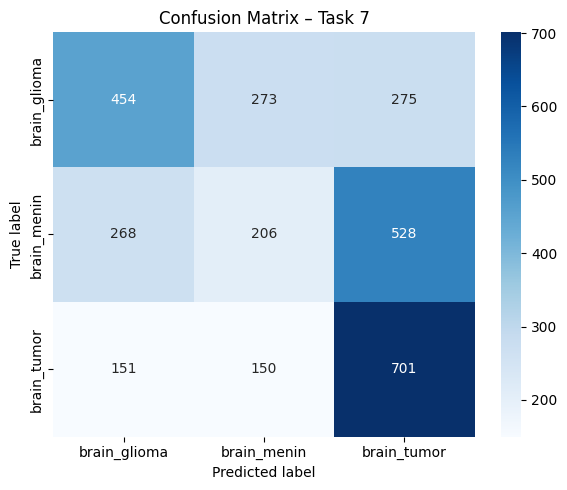

In [162]:
class_models, class_means = compute_latent_semantics_per_class_resnet(features_pt1, labels_pt1, k=10)


y_pred = predict_labels_with_latent_semantics(features_pt2, class_models, class_means)
evaluate_and_plot_confusion(labels_pt2, y_pred)


# Task 8

Implementa un programma che, per ciascuna etichetta univoca l, calcola i corrispondenti c cluster più significativi associati alle immagini della parte 1 (utilizzando l'algoritmo DBScan);
i cluster risultanti devono essere visualizzati sia
come nuvole di punti colorate in modo diverso in uno spazio MDS a 2 dimensioni, sia
come gruppi di miniature di immagini.

In [111]:
#Applichiamo tecniche di dimensionality reduction
def reduce_features(features, method, n_components, random_state=42):
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    else:
        raise ValueError(f"Metodo di riduzione '{method}' non supportato.")

    return reducer.fit_transform(features)

#Applichiamo una tecnica di riduzione mediante reduce_feature alle features di partenza ottenendo la lista di Feature Latenti
#Applichiamo su insieme di feature latenti StandardScaler per cercare di ottenere migliori cluster tramite DBSCAN

def apply_dbscan_with_pca(features, eps, min_samples, n_components, method):
    print(f"Applicazione di {method} -> Riduzione a {n_components} componenti")
    reduced_features = reduce_features(features, method, n_components=n_components)
    
    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels

#Calcola i 'c' cluster di maggior cardinalità
def top_c_clusters(cluster_labels, c):
    label_counts = Counter(cluster_labels)
    label_counts.pop(-1, None) # rimozione cluster catalogato come rumore (-1)
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i 'c' cluster più frequenti
    most_common = label_counts.most_common(c)
    top = [int(lbl) for lbl, _ in most_common]
    
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


#Applichiamo al risultato di DBSCAN l'algoritmo di MDS
def plot_mds_clusters(features, cluster_labels, top_clusters, metric):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    #Generazione di una nuova matrice basata sul parametro metric (es. 'cosine')
    D = pairwise_distances(features_scaled, metric=metric)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    Y = mds.fit_transform(D)

    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)
    
    plt.title(f"MDS 2D - Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()

#Genera blocco di immagini trovate per cluster
def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16-25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)
            
            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()

In [164]:
#main
def db_scan_detection(eps, min_samples, n_components, c, method):

    # Costruisce l’elenco dei full path per tutte le immagini
    base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
    images_full = [os.path.join(base_folder, lbl, fname) for fname, lbl in zip(filenames_pt1, labels_pt1)]

    # Scorre ogni label di Parte1 ed applico DBSCAN+PCA
    unique_labels = np.unique(labels_pt1)  # es. ["Glioma","Meningioma","Pituitary"]

    for lbl in unique_labels:
        print(f"\n============================")
        print(f"[INFO] Elaboro label: {lbl}")
        print(f"==============================")

        #Estrae le righe di feat_matrix_part1 / flname_part1 corrispondenti
        mask_lbl = (labels_pt1 == lbl)
        features_label = features_pt1[mask_lbl]   # shape = (n_i, d)
        images_label = np.array(images_full)[mask_lbl]

        #Chiama la tua funzione PCA + DBSCAN
        cluster_labels = apply_dbscan_with_pca(
            features_label,
            eps=eps,
            min_samples=min_samples,
            n_components=n_components,
            method = method
        )
        print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

        # Trova i c cluster più grandi
        top_clusters = top_c_clusters(cluster_labels, c)
        print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

        # MDS‐2D + scatter plot del clustering
        print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")

        plot_mds_clusters(
            features_label,
            cluster_labels,
            top_clusters,
            metric='cosine'
        )

        # Creo le miniature di ogni cluster “significativo”
        print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
        show_cluster_thumbnails(
            images_label,      # array di stringhe di percorsi
            cluster_labels,    # array di int di lunghezza n_i
            top_clusters,      # la lista dei c indici di cluster
            thumb_size=(64, 64)
        )

    print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")

In [113]:
eps = 5.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label
method = 'umap'       # umap or pca
db_scan_detection(eps, min_samples, n_components, c, method)


[INFO] Elaboro label: brain_glioma
Applicazione di umap -> Riduzione a 50 componenti


NameError: name 'umap' is not defined

# Task 9

Implementa un programma che, dati le immagini della parte 1:

*crea un classificatore m-NN (per una m specificata dall'utente),

*crea un classificatore ad albero decisionale,
Per questo task, puoi utilizzare lo spazio delle feature di tua scelta.    

Per le immagini della parte 2, prevede le etichette più probabili utilizzando il classificatore selezionato dall'utente.
Il sistema dovrebbe anche fornire valori di precisione, richiamo e punteggio F1 per etichetta, nonché un valore di accuratezza complessiva.    


In [165]:
# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(features_pt1, labels_pt1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(features_pt1, labels_pt1)

# Predizioni su Part2
pred_knn = knn_model.predict(features_pt2)
pred_dt = dt_model.predict(features_pt2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(labels_pt2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(labels_pt2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(labels_pt2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(labels_pt2, pred_dt))


Risultati m-NN:
              precision    recall  f1-score   support

brain_glioma       0.73      0.87      0.80      1002
 brain_menin       0.76      0.71      0.73      1002
 brain_tumor       0.89      0.78      0.83      1002

    accuracy                           0.79      3006
   macro avg       0.79      0.79      0.79      3006
weighted avg       0.79      0.79      0.79      3006

Accuratezza complessiva m-NN: 0.7870924817032602
Risultati Decision Tree:
              precision    recall  f1-score   support

brain_glioma       0.61      0.63      0.62      1002
 brain_menin       0.52      0.50      0.51      1002
 brain_tumor       0.67      0.66      0.67      1002

    accuracy                           0.60      3006
   macro avg       0.60      0.60      0.60      3006
weighted avg       0.60      0.60      0.60      3006

Accuratezza complessiva Decision Tree: 0.5994677312042581


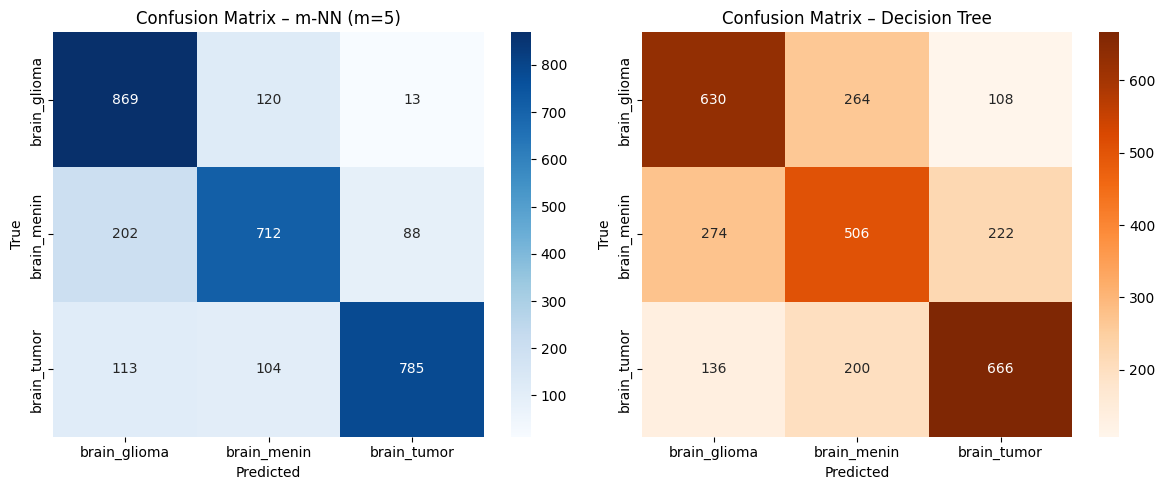

In [166]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ordine coerente delle classi
labels_order = np.unique(np.concatenate([labels_pt1, labels_pt2]))

# Calcolo delle confusion matrix
cm_knn = confusion_matrix(labels_pt2, pred_knn, labels=labels_order)
cm_dt  = confusion_matrix(labels_pt2, pred_dt,  labels=labels_order)

# Visualizzazione
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_knn, annot=True, fmt='d', ax=axs[0], cmap='Blues',
            xticklabels=labels_order, yticklabels=labels_order)
axs[0].set_title(f"Confusion Matrix – m-NN (m={m})")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(cm_dt, annot=True, fmt='d', ax=axs[1], cmap='Oranges',
            xticklabels=labels_order, yticklabels=labels_order)
axs[1].set_title("Confusion Matrix – Decision Tree")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

plt.tight_layout()
plt.show()


# Task 10

> 10a:

 Implementa uno strumento di Locality Sensitive Hashing (LSH) (per la distanza euclidea) che prende come input (a) il numero di livelli, L, (b) il numero di hash per livello, h, e (c) un insieme di vettori come input e crea una struttura di indice in memoria contenente l'insieme di vettori dato. 

Vedi:
"Near-Optimal Hashing Algorithms for Approximate Nearest Neighbor in High Dimensions" (di Alexandr Andoni e Piotr Indyk). Communications of the ACM, vol. 51, no. 1, 2008, pp. 117-122.    



In [119]:
class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea con quantizzazione (p-stable).
    num_layers = L, num_hashes = h, dim = D, r = bucket width.
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        self.hash_tables = [defaultdict(list) for _ in range(self.L)]
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        bits = []
        for j in range(self.h):
            a_j = self.a_vectors[layer_idx][j]
            b_j = self.b_offsets[layer_idx][j]
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            bits.append(h_val)
        return tuple(bits)

    def index(self, vectors: np.ndarray):
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Dimensione vettore ({D}) ≠ D di LSH ({self.d})."
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        assert q_vec.shape[0] == self.d, "Dimensione query ≠ D."
        candidati = set()
        total_checked = 0
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked
    
    def get_stats(self):
        """Restituisce statistiche sull'indice LSH con quantizzazione"""
        total_buckets = sum(len(table) for table in self.hash_tables)
        non_empty_buckets = sum(
            1 for table in self.hash_tables for bucket in table.values() if bucket
        )
        all_bucket_sizes = [len(bucket) for table in self.hash_tables for bucket in table.values() if bucket]

        return {
            'total_vectors': len(self.data_vectors),
            'layers': self.L,
            'hashes_per_layer': self.h,
            'total_buckets': total_buckets,
            'non_empty_buckets': non_empty_buckets,
            'avg_bucket_size': np.mean(all_bucket_sizes) if all_bucket_sizes else 0
        }

Test

In [120]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(features_pt1, axis=0)
feat_centered = features_pt1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 5                      # numero di funzioni concatenati in ciascuna tavola
r = 1                      # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)
lsh_quant.index(feat_normed)
stats = lsh_quant.get_stats()
print("\n[STATISTICHE LSH-Quant]")
for k, v in stats.items():
    print(f"{k}: {v}")

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")



[STATISTICHE LSH-Quant]
total_vectors: 3006
layers: 10
hashes_per_layer: 5
total_buckets: 10957
non_empty_buckets: 10957
avg_bucket_size: 5.486903349456968
[INFO] LSH quantizzato costruito: D=1024, L=10, h=5, r=1


> 10b:

 Implementa un algoritmo di ricerca di immagini simili utilizzando questa struttura di indice che memorizza le immagini della parte 1 e un modello visivo di tua scelta (il modello visivo combinato deve avere almeno 256 dimensioni): per una data immagine di query e un numero intero t, 
 
*visualizza le t immagini più simili,
*fornisce il numero di immagini univoche e il numero complessivo di immagini considerate durante il processo.    

In [117]:
def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Trova le k immagini più simili a img_path (di Part2) usando lsh_quant costruito su Part1.
    """
    # 1) Estrai feature raw (900-dim)
    print(img_path)
    raw_q = np.array(extractor.extract_feature(img_path), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec usato su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampo i risultati testuali
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = labels_pt1[idx]
        fname = filenames_pt1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = labels_pt1[idx]
        fname = filenames_pt1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


Test

Part2/brain_menin/brain_menin_1003.jpg

[LSH-Quant] Top 5 simili a: Part2/brain_menin/brain_menin_1003.jpg
  1. brain_menin_0554.jpg | Classe: brain_menin | Distanza Euclidea: 0.84
  2. brain_menin_0121.jpg | Classe: brain_menin | Distanza Euclidea: 1.05
  3. brain_menin_0252.jpg | Classe: brain_menin | Distanza Euclidea: 1.11
  4. brain_glioma_0641.jpg | Classe: brain_glioma | Distanza Euclidea: 1.12
  5. brain_tumor_0344.jpg | Classe: brain_tumor | Distanza Euclidea: 1.13
[LSH-Quant] Immagini uniche considerate: 26
[LSH-Quant] Immagini totali controllate: 27


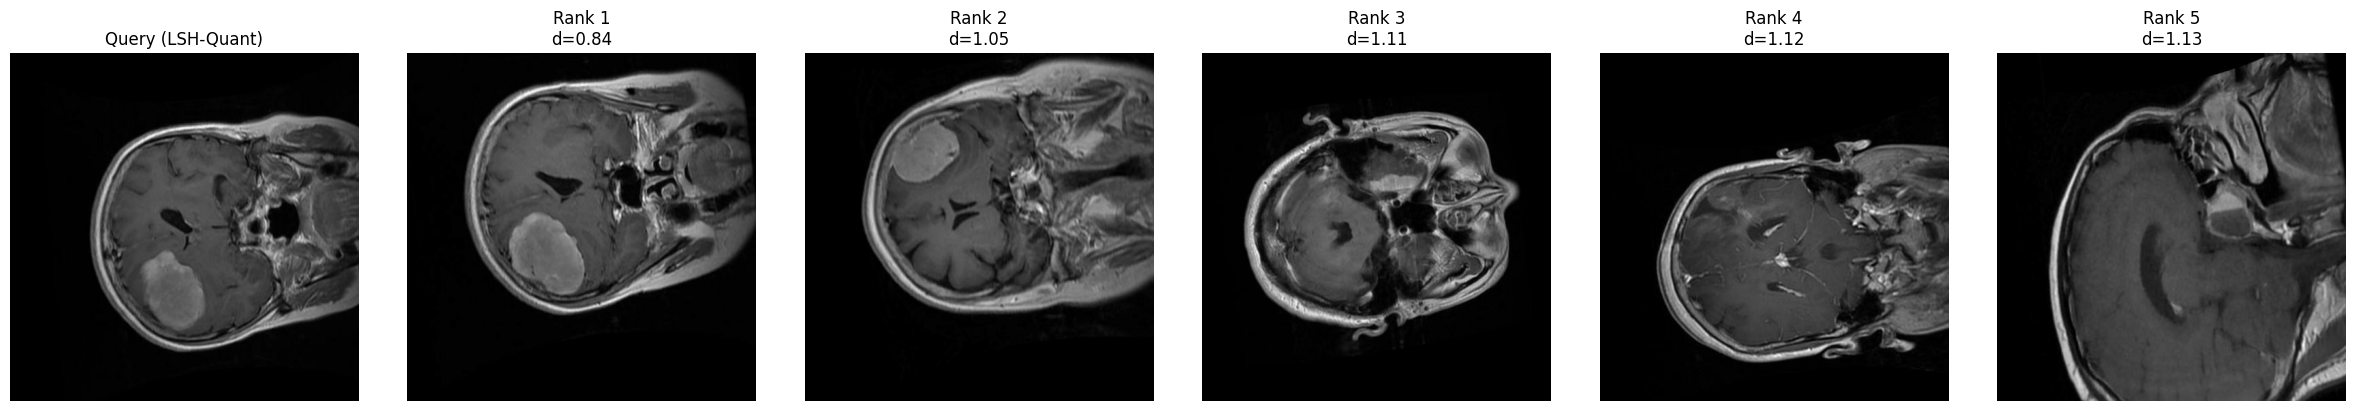

In [118]:
# Utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_menin/brain_menin_1003.jpg"

k = 5                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)